In [1]:
import torch
import gzip
import numpy as np
import matplotlib.pyplot as plt
import sys

sys.path.append("..")
from functions.sam_functions import batch_sample_from_class, multiclass_prob_batched
from functions.modified_predictor import modifiedPredictor

In [2]:
embeddings = torch.load(
    "/Users/lisa/Documents/Master/sam-lab/ACDC/database/embeddings/embeddings.pt"
)

In [5]:
embeddings.shape

torch.Size([2978, 256, 64, 64])

# batched prompts

In [3]:
ground_truth_path = (
    "/Users/lisa/Documents/Master/sam-lab/ACDC/database/preprocess/ground_truth.npy.gz"
)
with gzip.open(ground_truth_path, "rb") as f:
    # Load the NumPy array from the file
    ground_truths = np.load(f)

In [3]:
ground_truth = ground_truths[0]
ground_truth = torch.tensor(ground_truth)
points, labels = batch_sample_from_class(2, ground_truth, 1, 15, 5)

In [7]:
# plt.imshow(ground_truth)
# show_points(points, labels, ax=plt.gca())

In [4]:
labels

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0]])

In [5]:
points

tensor([[[110,  64],
         [115,  58],
         [ 90,  70],
         [116,  72],
         [ 91,  82],
         [ 92,  86],
         [120,  73],
         [ 82,  81],
         [ 94,  75],
         [ 94,  80],
         [114,  61],
         [110,  53],
         [ 89,  68],
         [101,  88],
         [ 93,  70],
         [105,  94],
         [125,  97],
         [110, 128],
         [112, 109],
         [111,  84]],

        [[ 99,  63],
         [103,  60],
         [ 83,  85],
         [ 87,  75],
         [ 89,  85],
         [ 84,  80],
         [105,  78],
         [ 93,  93],
         [ 94,  80],
         [ 95,  73],
         [108,  70],
         [ 79,  82],
         [101,  75],
         [ 88,  92],
         [ 81,  94],
         [135,  89],
         [118, 127],
         [118,  89],
         [118, 102],
         [135, 114]]])

In [4]:
logits_stack = torch.rand((2, 3, 4, 4))  # Replace with your actual tensor
result = multiclass_prob_batched(logits_stack, hard_labels=False)
sum_along_axis1 = torch.sum(result, dim=1)
# Check if the sum along axis=1 is close to 1 everywhere
is_sum_equal_to_1 = torch.allclose(sum_along_axis1, torch.ones_like(sum_along_axis1))
print(is_sum_equal_to_1)

True


In [4]:
mp = modifiedPredictor()
embedding = embeddings[0]
ground_truth = torch.tensor(ground_truths[0])

In [5]:
pr1 = batch_sample_from_class(2, ground_truth, 1, 10, 5)
pr2 = batch_sample_from_class(2, ground_truth, 2, 10, 5)
pr3 = batch_sample_from_class(2, ground_truth, 3, 10, 5)

In [6]:
logit_class_1 = mp.predict(embedding, pr1[0], pr1[1])
logit_class_2 = mp.predict(embedding, pr2[0], pr2[1])
logit_class_3 = mp.predict(embedding, pr3[0], pr3[1])
logit_stack = torch.cat([logit_class_1, logit_class_2, logit_class_3], dim=1)

In [9]:
logit_stack.shape

torch.Size([2, 3, 256, 216])

In [10]:
logit_stack

tensor([[[[-16.4969, -17.2271, -18.6151,  ..., -17.9918, -14.9119, -16.8710],
          [-14.7923, -19.2765, -16.9285,  ..., -18.6485, -14.8113, -16.8919],
          [-17.1375, -18.8551, -18.6606,  ..., -18.7535, -16.6231, -18.4110],
          ...,
          [-14.6247, -19.0431, -16.7438,  ..., -22.3000, -17.0206, -20.1476],
          [-16.7500, -18.4509, -18.4963,  ..., -19.9104, -18.5216, -19.1691],
          [-14.4815, -19.9392, -15.6567,  ..., -19.4850, -15.6559, -17.2741]],

         [[-13.4718, -14.4012, -14.9464,  ..., -15.3979, -12.2027, -14.5590],
          [-13.5992, -15.2964, -15.2014,  ..., -15.9945, -13.8824, -14.6202],
          [-14.7485, -16.0660, -16.0863,  ..., -16.6892, -14.1657, -16.1710],
          ...,
          [-12.9583, -15.4862, -14.9173,  ..., -16.7471, -14.6890, -15.8117],
          [-13.5606, -15.5310, -15.5656,  ..., -16.4067, -14.9164, -15.8878],
          [-13.0552, -16.3341, -13.8903,  ..., -15.5831, -13.7964, -14.0047]],

         [[-14.6178, -15.3621,

In [7]:
masks = multiclass_prob_batched(logit_stack)

In [8]:
mask = masks[0]

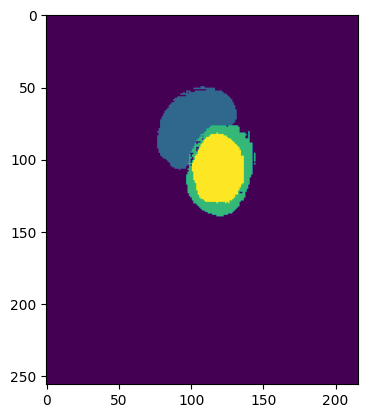

In [9]:
plt.imshow(mask.squeeze())

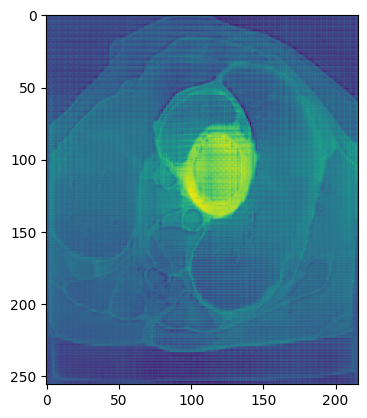

In [19]:
plt.imshow(logit_stack[0][1])